# An Evaluation of Naive Bayesian Anti-Spam Filtering
<b>Authors:</b> John Israel Caingles, Kingston Anthony Koa and Juan Lorenzo Simeon
<hr>
## Description
A tutorial for the reimplementation of the paper with the same name by Ion Androutsopoulos, John Koutsias, Konstantinos  Chandrinos, George Paliouras and Constantine Spyropoulos (2000). It uses a Naive Bayesian classifier to filter spam e-mails on a corpus found in the emails folder. The effect of attribute size, lemmatization and the use of stop-lists, among other variables, on the performance of the filter is explored.

<hr>
## Preparing the Tests
For each test, we perform a ten-fold cross-validation. This means that out of the 10 folders, one is selected and the nine others are used as training data. This is iterated for each of the folders and the averages of the results are computed. <b>For this tutorial, we will show how we implemented one test from the ten-fold cross-validation. The complete implementation is found in the file [spamfiltering.py](spamfiltering.py)</b> 

We first prepare the needed libraries.

In [1]:
import os
import re
import math
import numpy
from __future__ import division

We define an array of dictionaries, as well as arrays to hold the different probabilities for each folder chosen. 

In [2]:
word_dic_list = [{} for k in range(10)]
SPAM_PROBABILITY = [0.0 for k in range(10)]
HAM_PROBABILITY = [0.0 for k in range(10)]

For each test, we alter the configuration by settting the attirbute size (num_of_top_attributes), threshold lambda (threshold_lambda), and which data sets are to be used (filter_config)  depending on what is required. 

For the purpose of this tutorial, here I set the filter to use only the top 50 attributes, use a lambda of 1 and use the bare words (lemmetizer and stop-list are off).

In [3]:
num_of_top_attributes = 50
threshold_lambda = 1.0
filter_config = 'bare'
email_dir = 'emails/' + filter_config

For each iteration (where we choose one folder to test and nine to train), we also intialize the following variables to enable the filter to be retrained on the data set required and for the results to be recalculated.

In [4]:
#word_dic_list[words_dic_index].clear()
attribs_dic = {}
spam_count = 0.0
ham_count = 0.0

## Training the Filter
The filter is then trained using the e-mails from the 9 folders. For each message, regular expressions are used to obtain only the words without any unwanted characters and the letters are all changed to lowercase. 

In [5]:
def getWordsFromEmail(content):
    content = re.sub('[^a-zA-Z]+', ' ', content)
    content = content.lower()
    return content.split()

We can now use the resulting array of words to train the filter. We do this by adding it to a dictionary, named words_dic, whose key is a string, which is the word and the value is a Word object. If the word occurs in the document, we add the word's count in its class, depending on whether the document it occurred in is spam or ham. 

In [6]:
class Word:
    def __init__(self):
        self.spamOccurence = 0
        self.hamOccurence = 0
        self.spamProbability = 0.0
        self.hamProbability = 0.0
        self.content = ''
        self.mutualInfo = 0.0
        
    def addToSpamOccur(self, n):
        self.spamOccurence +=n
    def addToHamOccur(self, n):
        self.hamOccurence +=n
    def getSpamOccur(self):
        return self.spamOccurence
    def getHamOccur(self):
        return self.hamOccurence
    def getContent(self):
        return self.content
    def setContent(self, n):
        self.content = n
    def getSpamProbability(self):
        return self.spamProbability
    def setSpamProbability(self, n):
        self.spamProbability = n
    def getHamProbability(self):
        return self.hamProbability
    def setHamProbability(self, n):
        self.hamProbability = n
    def getMutualInfo(self):
        return self.mutualInfo
    def setMutualInfo(self, n):
        self.mutualInfo = n

In [7]:
def train(content, email_type, words_dic_index):
    allwords_array = getWordsFromEmail(content)
    words_array = set(allwords_array) #remove duplicates
    for word in words_array:
        word_obj = word_dic_list[words_dic_index].get(word, None)
        if word_obj is None:
            word_obj = Word()
            word_obj.setContent(word)

        if email_type == 'spam':
            word_obj.addToSpamOccur(1)
        else:
            word_obj.addToHamOccur(1)
        word_dic_list[words_dic_index][word] = word_obj

We run this function for every word in every email of the data set for training. For this tutorial, I will choose the bare/part1 folder as our test folder.

In [8]:
test_folder_index = 1

We must also compute the probability of spam and ham that occurs in the training set. One thing to note is the use of <i>Laplace Smoothing</i> which uses epsilon, which we set to 1.0 later. This is to account for the zero occurrence of a word in a certain class (either spam or ham), setting it so that the probability does not become 0 but instead a small positive number.

In [9]:
for num in range(1, 11):
    if num != test_folder_index:
        part_num = num
        part_folder = '/part' + str(part_num)
        for filename in os.listdir(email_dir + part_folder):
            email_type = 'ham'
            if 'sp' in filename:
                email_type = 'spam'
                spam_count += 1
            else:
                ham_count += 1
            email_file = open(email_dir + part_folder + "/" + filename, "r")
            content = email_file.read()
            train(content, email_type, test_folder_index - 1)

In [10]:
def computeForSpamProbability(spam_count, ham_count):
    return spam_count/(spam_count+ham_count)

def computeForHamProbability(spam_count, ham_count):
    return ham_count/(spam_count+ham_count)

def computeForSpamWordProbability(occurence, spam_count, epsilon):
    return (occurence+1*epsilon)/(spam_count+2*epsilon)

def computeForHamWordProbability(occurence, ham_count, epsilon):
    return (occurence+1*epsilon)/(ham_count+2*epsilon)

We save this in an array so that we can also store the probabilities given other training sets later on.

In [11]:
epsilon = 1.0
SPAM_PROBABILITY[test_folder_index - 1] = computeForSpamProbability(spam_count, ham_count)
HAM_PROBABILITY[test_folder_index - 1] = computeForHamProbability(spam_count, ham_count)

for word, word_obj in word_dic_list[test_folder_index - 1].iteritems():
    word_dic_list[test_folder_index - 1].get(word).setSpamProbability(
        computeForSpamWordProbability(word_obj.getSpamOccur(), spam_count, epsilon))
    word_dic_list[test_folder_index - 1].get(word).setHamProbability(
        computeForHamWordProbability(word_obj.getHamOccur(), ham_count, epsilon))

## Selecting Attributes
To select attributes among all the words, only the top <i>n</i> (n being the variable attrib_size) attributes with the highest mutual information (MI) will be chosen. This is calculated using the same equation as in the paper. We added exception handling to estimate the computation in case of a very small value which may lead to a ValueError due to the logarithm of zero (as a result of a very small value).

In [12]:
def computeMI(words_dic_index):
    total = ham_count + spam_count
    for key, value in word_dic_list[words_dic_index].iteritems():
        spam_occur = value.getSpamOccur()
        spam_notoccur = spam_count - spam_occur
        ham_occur = value.getHamOccur()
        ham_notoccur = total - value.getHamOccur()
        try:
            mutual_info = (spam_occur / total) * math.log((total * spam_occur) / \
                                                          ((spam_occur + ham_occur) * (spam_occur + spam_notoccur)))
        except:
            mutual_info = 0.0
        try:
            mutual_info += (spam_notoccur / total) * math.log((total * spam_notoccur) / \
                                                              ((spam_notoccur + ham_notoccur) * (spam_occur + spam_notoccur)))
        except:
            mutual_info += 0.0
        try:
            mutual_info += (ham_occur / total) * math.log((total * ham_occur) / \
                                                          ((spam_occur + ham_occur) * (ham_occur + ham_notoccur)))
        except:
            mutual_info += 0.0
        try:
            mutual_info += (ham_notoccur / total) * math.log((total * ham_notoccur) / \
                                                             ((spam_notoccur + ham_notoccur) * (ham_occur + ham_notoccur)))
        except:
            mutual_info += 0.0
        word_dic_list[words_dic_index][key].setMutualInfo(mutual_info)
        
computeMI(test_folder_index-1)

In [13]:
def getTopAttribs(n, words_dic_index):
    values_dic = word_dic_list[words_dic_index]
    sorted_dic = sorted(values_dic.values(), key=lambda word: word.mutualInfo, reverse=True)
    top_n = sorted_dic[:n]
    attribs_dic = {}
    for word in top_n:
        attribs_dic[word.getContent()] = word
    return attribs_dic

For example, print the top 5 words:

In [14]:
for word in getTopAttribs(5, test_folder_index-1):
    print word

language
you
remove
free
your


## Testing an E-mail using Naive Bayes
After we have chosen the attributes, we can then proceed to classifying the e-mails (the test folder). We calculate for the probability that an e-mail is spam based on Bayes' theorem. We use the data that we collected during the training to compute for the probabilities needed. One thing to note is the use of the summation of the log probabilities instead of the product of the probabilities. This is to prevent the underflow of the probabilities, especially when the attribute size is large.

In [15]:
def computeProbabilityForListOfWords(attribs_dic, word_list, email_type):
    answer = 0.0
    for word, word_obj in attribs_dic.iteritems():
        isWordIncluded = False

        for word_list_word in word_list:
            if word == word_list_word:
                isWordIncluded = True

        multiplicand = 1.0
        if email_type == 'spam':
            multiplicand = word_obj.getSpamProbability()
        else:
            multiplicand = word_obj.getHamProbability()

        if isWordIncluded is False:
            multiplicand = 1.0 - multiplicand
            
        answer += math.log(multiplicand)
    return answer

In [16]:
def computeBayesianProbability(spam_prob, ham_prob, word_spam_prob, word_ham_prob, email_type):
    if email_type is 'spam':
        return word_spam_prob + math.log(spam_prob) -\
            numpy.logaddexp(word_spam_prob + math.log(spam_prob), word_ham_prob + math.log(ham_prob))
    else:
        return word_ham_prob + math.log(ham_prob) -\
            numpy.logaddexp(word_ham_prob + math.log(ham_prob), word_spam_prob + math.log(spam_prob))

The classification is not finished here, as how can we conclude that an e-mail is spam or ham depending on the probability? We use a threshold, lambda, as defined earlier, which is how much more times is classifying a ham e-mail as spam more costly than classifying a spam e-mail as ham.

In [17]:
def checkSpamHam(threshold, prob_spam):
    t = threshold / (threshold + 1)
    if (prob_spam > math.log(t)):
        return 'spam'
    return 'ham'

We can now complete our function to classify each e-mail as spam or ham!

In [18]:
def testEmail(test_email, words_dic_index):
    attribs_dic = getTopAttribs(num_of_top_attributes, words_dic_index)
    email_file = open(test_email, "r")
    content = email_file.read()
    word_list = getWordsFromEmail(content)
    word_list = set(word_list)  # remove duplicates

    word_spam_prob = computeProbabilityForListOfWords(attribs_dic, word_list, "spam")
    word_ham_prob = computeProbabilityForListOfWords(attribs_dic, word_list, "ham")
    email_type = "spam"
    baye_probability = computeBayesianProbability(SPAM_PROBABILITY[words_dic_index], HAM_PROBABILITY[words_dic_index], 
                                                      word_spam_prob, word_ham_prob, email_type)
    return checkSpamHam(threshold_lambda, baye_probability)

## Running Tests
After implementing the previous functions, we can now use them to test our entire test folder. We take note of the emails that it classified correctly (spam classified as spam, ham classified as ham), the false positives (ham classified as spam), the false negatives (spam classified as ham) and the true count of spam and ham present in the test set.

In [19]:
spam_fp_count = 0.0
spam_fn_count = 0.0
spam_correct_count = 0.0
ham_correct_count = 0.0
spam_true_count = 0.0
ham_true_count = 0.0
part_folder = '/part'
for filename in os.listdir(email_dir + part_folder + str(test_folder_index)):
    # check what the test email really is
    if 'sp' in filename:
        test_email_type = 'spam'
        spam_true_count += 1
    else:
        test_email_type = 'ham'
        ham_true_count += 1
    bayesian_result = testEmail(email_dir + part_folder + str(test_folder_index) + "/" + filename, test_folder_index-1)
    # update results for analysis
    if bayesian_result == 'spam' and test_email_type == 'spam':
        spam_correct_count += 1
    elif bayesian_result == 'ham' and test_email_type == 'ham':
        ham_correct_count += 1
    elif bayesian_result == 'spam' and test_email_type == 'ham':
        spam_fp_count += 1
    elif bayesian_result == 'ham' and test_email_type == 'spam':
        spam_fn_count += 1

We can use this to compute the filter's performance for the single test folder!

In [20]:
print 'SAMPLE RESULTS'
print_value = (spam_correct_count / (spam_correct_count + spam_fn_count)) * 100
print 'Spam Recall: %.2f %%' % print_value
print_value = (spam_correct_count / (spam_correct_count + spam_fp_count)) * 100
print 'Spam Precision: %.2f %%' % print_value
print_value = ((threshold_lambda * ham_correct_count + spam_correct_count) / (
                threshold_lambda * ham_true_count + spam_true_count)) * 100
print 'Weighted Accuracy: %.2f %%' % print_value
print_value = ( (threshold_lambda * ham_true_count) / (threshold_lambda * ham_true_count + spam_true_count)) * 100
print 'Baseline Weighted Accuaracy: %.2f %%' % print_value
print_value = (spam_true_count / (threshold_lambda * spam_fp_count + spam_fn_count))
print 'TCR: %.2f \n' % print_value

SAMPLE RESULTS
Spam Recall: 85.42 %
Spam Precision: 97.62 %
Weighted Accuracy: 97.23 %
Baseline Weighted Accuaracy: 83.39 %
TCR: 6.00 



This process is then repeated multiple times to perform ten-fold cross-validation and also to account for the different values and filter configurations. We save the results for each test in a .csv file which we then show below.

## Results
Similar to the paper, we measure our performance using the total cost ratio (TCR), in which a higher TCR means a better performance. We show below the TCR for the three lambda thresholds (1, 9, 999), the increaing attribute sizes (50-700, step = 50) and whether the lemmatizer and/or stop-list is used.

The graphs that follow are generated from [results.csv](results.csv) which was generated by our program beforehand. Also included in the .csv is the Spam Recall, Spam Precision, Weighted Accuracy and the Baseline Weighted Accuracy.

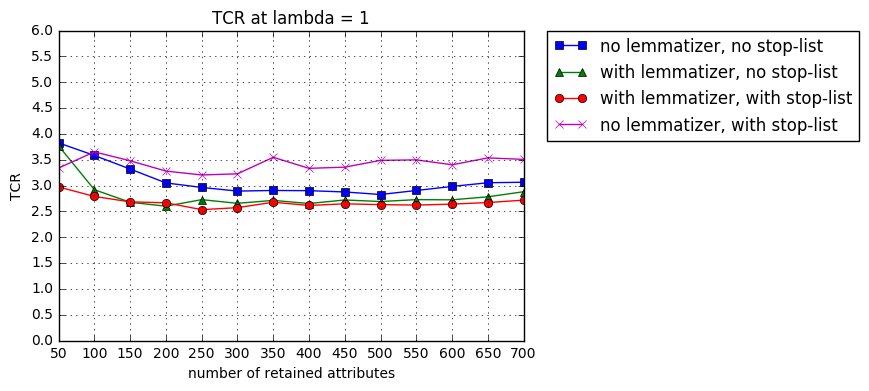

In [21]:
import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
filename = "results.csv"
with open(filename, 'rb') as f:
    results = list(csv.reader(f))

bare_x = []
bare_y = []
lemm_x = []
lemm_y = []
lemm_stop_x = []
lemm_stop_y = []
stop_x = []
stop_y = []

for data in results:
    if data[0] == 'bare' and int(data[1]) == 1:
        bare_x.append(int(data[2]))
        bare_y.append(float(data[7]))
    elif data[0] == 'lemm' and int(data[1]) == 1:
        lemm_x.append(int(data[2]))
        lemm_y.append(float(data[7]))
    elif data[0] == 'lemm_stop' and int(data[1]) == 1:
        lemm_stop_x.append(int(data[2]))
        lemm_stop_y.append(float(data[7]))
    elif data[0] == 'stop' and int(data[1]) == 1:
        stop_x.append(int(data[2]))
        stop_y.append(float(data[7]))

plt.title('TCR at lambda = 1')
plt.plot(bare_x, bare_y, '-bs', label='no lemmatizer, no stop-list')
plt.plot(lemm_x, lemm_y, '-g^', label='with lemmatizer, no stop-list')
plt.plot(lemm_stop_x, lemm_stop_y, '-ro', label='with lemmatizer, with stop-list')
plt.plot(stop_x, stop_y, '-mx', label='no lemmatizer, with stop-list')
plt.axis([50, 700, 0.0, 6.0])
plt.xlabel("number of retained attributes")
plt.ylabel("TCR")
plt.xticks(np.arange(50, 701, 50))
plt.yticks(np.arange(0.0, 6.1, 0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

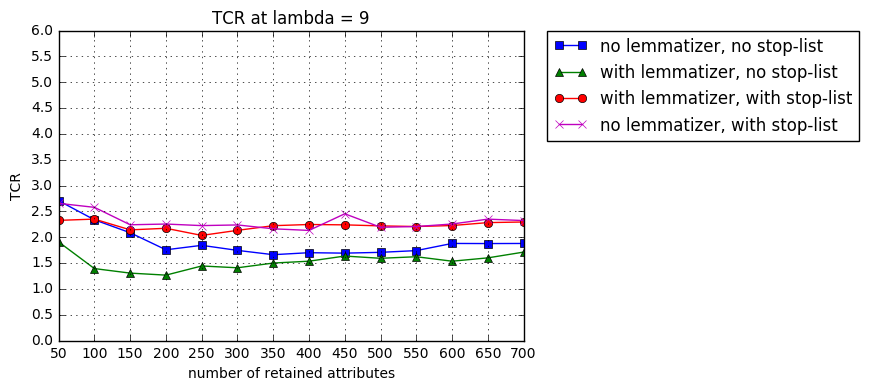

In [22]:
bare_x = []
bare_y = []
lemm_x = []
lemm_y = []
lemm_stop_x = []
lemm_stop_y = []
stop_x = []
stop_y = []

for data in results:
    if data[0] == 'bare' and int(data[1]) == 9:
        bare_x.append(int(data[2]))
        bare_y.append(float(data[7]))
    elif data[0] == 'lemm' and int(data[1]) == 9:
        lemm_x.append(int(data[2]))
        lemm_y.append(float(data[7]))
    elif data[0] == 'lemm_stop' and int(data[1]) == 9:
        lemm_stop_x.append(int(data[2]))
        lemm_stop_y.append(float(data[7]))
    elif data[0] == 'stop' and int(data[1]) == 9:
        stop_x.append(int(data[2]))
        stop_y.append(float(data[7]))
        
plt.title('TCR at lambda = 9')
plt.plot(bare_x, bare_y, '-bs', label='no lemmatizer, no stop-list')
plt.plot(lemm_x, lemm_y, '-g^', label='with lemmatizer, no stop-list')
plt.plot(lemm_stop_x, lemm_stop_y, '-ro', label='with lemmatizer, with stop-list')
plt.plot(stop_x, stop_y, '-mx', label='no lemmatizer, with stop-list')
plt.axis([50, 700, 0.0, 6.0])
plt.xlabel("number of retained attributes")
plt.ylabel("TCR")
plt.xticks(np.arange(50, 701, 50))
plt.yticks(np.arange(0.0, 6.1, 0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

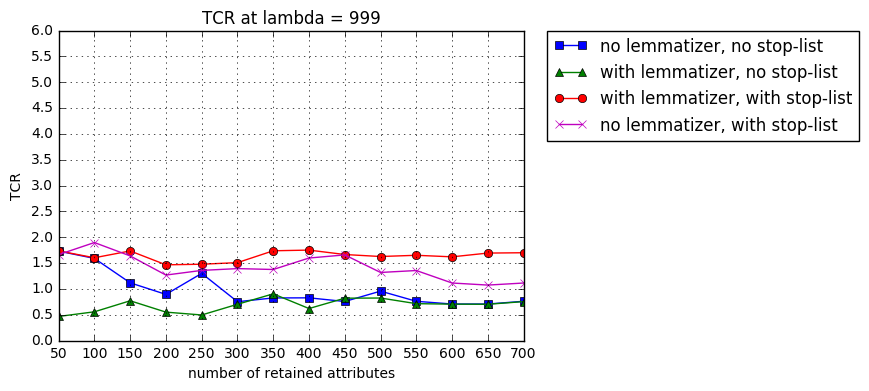

In [23]:
bare_x = []
bare_y = []
lemm_x = []
lemm_y = []
lemm_stop_x = []
lemm_stop_y = []
stop_x = []
stop_y = []

for data in results:
    if data[0] == 'bare' and int(data[1]) == 999:
        bare_x.append(int(data[2]))
        bare_y.append(float(data[7]))
    elif data[0] == 'lemm' and int(data[1]) == 999:
        lemm_x.append(int(data[2]))
        lemm_y.append(float(data[7]))
    elif data[0] == 'lemm_stop' and int(data[1]) == 999:
        lemm_stop_x.append(int(data[2]))
        lemm_stop_y.append(float(data[7]))
    elif data[0] == 'stop' and int(data[1]) == 999:
        stop_x.append(int(data[2]))
        stop_y.append(float(data[7]))
        
plt.title('TCR at lambda = 999')
plt.plot(bare_x, bare_y, '-bs', label='no lemmatizer, no stop-list')
plt.plot(lemm_x, lemm_y, '-g^', label='with lemmatizer, no stop-list')
plt.plot(lemm_stop_x, lemm_stop_y, '-ro', label='with lemmatizer, with stop-list')
plt.plot(stop_x, stop_y, '-mx', label='no lemmatizer, with stop-list')
plt.axis([50, 700, 0.0, 6.0])
plt.xlabel("number of retained attributes")
plt.ylabel("TCR")
plt.xticks(np.arange(50, 701, 50))
plt.yticks(np.arange(0.0, 6.1, 0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

From the results, we can see that the TCR values that we found are similar to the ones in the paper. There may have been errors in comparison to the paper due to the (1) adding of Laplace Smoothing to the probability (with our own epsilon set as 1), (2) loss of precision when digits become too small and (3) human error while implementing the project. Overall, the filter performs as the filter in the paper performs --  better when the cost of classifying ham as spam is lower.